# Uncertainty quantification using "DRIVE: Digital Retinal Images for Vessel Extraction" dataset
 
__author__: Yongchan Kwon

This note shows an example of the use of the method introduced in the paper "Uncertainty quantification using Bayesian neural networks in classification: Application to biomedical segmentation".

This notebook is based on the Walter de Back's amazing notebook https://gitlab.com/wdeback/dl-keras-tutorial/blob/master/notebooks/3-cnn-segment-retina-uncertainty.ipynb I really recommend to see together. 

**Reference**

- J.J. Staal, M.D. Abramoff, M. Niemeijer, M.A. Viergever, B. van Ginneken, "Ridge based vessel segmentation in color images of the retina", IEEE Transactions on Medical Imaging, 2004, vol. 23, pp. 501-509.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, glob
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
np.random.seed(20180621)

from skimage.external import tifffile # read tiff images
from skimage.io import imread # read gif images
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import seaborn as sns

from model import *
import utils
import time

plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
print('Backend: ', K.backend())
print('Image_data_format: ', K.image_data_format())
N_train = 2000

Backend:  tensorflow
Image_data_format:  channels_last


In [3]:
# load training images
fns = sorted(glob.glob('./input/training/images/*.tif'))
x_train = np.array([tifffile.imread(fn) for fn in fns])

# load test images
fns = sorted(glob.glob('./input/test/images/*.tif'))
x_test = np.array([tifffile.imread(fn) for fn in fns])
print('shape of raw train data: ', x_train.shape)
print('shape of raw test data: ',x_test.shape)

/usr/local/lib/python3.5/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


shape of raw train data:  (20, 584, 565, 3)
shape of raw test data:  (20, 584, 565, 3)


In [4]:
 # load training annotations
fns = sorted(glob.glob('./input/training/1st_manual/*.gif'))
y_train = np.array([imread(fn) for fn in fns]) # read images
y_train = np.expand_dims(y_train, -1) # add channels dimension

# load test annotations
fns = sorted(glob.glob('./input/test/1st_manual/*.gif'))
y_test = np.array([imread(fn) for fn in fns]) # read images
y_test = np.expand_dims(y_test, -1) # add channels dimension
print('train shape:', y_train.shape)
print('test shape:', y_test.shape)

train shape: (20, 584, 565, 1)
test shape: (20, 584, 565, 1)


## Preprecossing

In [5]:
x_train = utils.preprocess(x_train)
x_test = utils.preprocess(x_test)

y_train = utils.preprocess(y_train)
y_test = utils.preprocess(y_test)

min: 0.0, max: 1.0, shape: (20, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (20, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (20, 584, 565, 1), type: float32
min: 0.0, max: 1.0, shape: (20, 584, 565, 1), type: float32


In [6]:
X_train, Y_train = utils.get_random_snippets(x_train, y_train, number=N_train, size=(96,96))
X_test, Y_test = utils.get_random_snippets(x_test, y_test, number=1000, size=(96,96))

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

X_train shape:  (2000, 96, 96, 3)
Y_train shape:  (2000, 96, 96, 1)
X_test shape:  (1000, 96, 96, 3)
Y_test shape:  (1000, 96, 96, 1)


<Figure size 1440x1440 with 0 Axes>

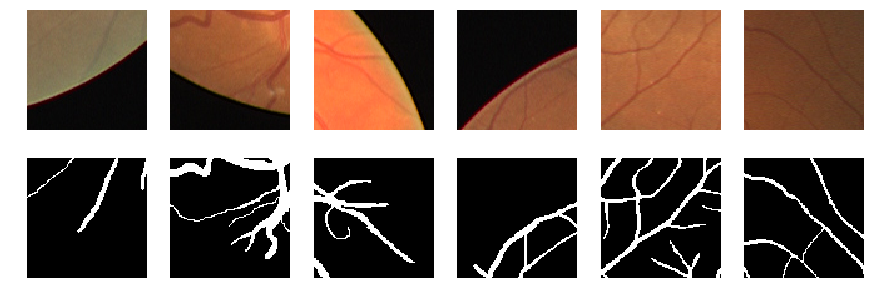

In [7]:
plt.rcParams['figure.figsize'] = [15, 5]
M=6
list_index = np.random.randint(low=0, high=X_train.shape[0], size=M)
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(2,M)
for k, ind in enumerate(list_index):
    ax[0,k].imshow(X_train[ind])
    ax[1,k].imshow(Y_train[ind,:,:,0], cmap='gray')
    
    ax[0,k].axis('off')
    ax[1,k].axis('off')

fig.savefig('./fig/DRIVE_example_2000.pdf')

In [8]:
model = UNet(N_filters=16)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', dice_coefficient, precision_smooth, recall_smooth])
print("Number of parameters: ", model.count_params())

Number of parameters:  1115265


In [9]:
batch_size = 32
epochs = 200
info_check_string='./weights/DRIVE_stochastic_sample_2000.hdf5'
early_stopping=EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint=ModelCheckpoint(info_check_string, monitor='loss', save_best_only=True)

In [10]:
history = model.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True,
                      verbose=1,
                      validation_split=0.2, # 4 samples are used for a validation set
                      callbacks=[early_stopping, model_checkpoint]) 

Train on 1600 samples, validate on 400 samples
Epoch 1/200
1600/1600 [==============================] - 8s 5ms/step - loss: 0.7295 - binary_accuracy: 0.5715 - dice_coefficient: 0.2057 - precision_smooth: 0.1281 - recall_smooth: 0.5255 - val_loss: 0.7339 - val_binary_accuracy: 0.6052 - val_dice_coefficient: 0.2155 - val_precision_smooth: 0.1346 - val_recall_smooth: 0.5431
Epoch 2/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.4991 - binary_accuracy: 0.7938 - dice_coefficient: 0.3222 - precision_smooth: 0.2106 - recall_smooth: 0.6973 - val_loss: 0.3958 - val_binary_accuracy: 0.8671 - val_dice_coefficient: 0.3791 - val_precision_smooth: 0.2686 - val_recall_smooth: 0.6463
Epoch 3/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.3251 - binary_accuracy: 0.9244 - dice_coefficient: 0.4196 - precision_smooth: 0.2997 - recall_smooth: 0.7098 - val_loss: 0.2454 - val_binary_accuracy: 0.9226 - val_dice_coefficient: 0.4068 - val_precision_smooth: 0.3835 

Epoch 26/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.1186 - binary_accuracy: 0.9551 - dice_coefficient: 0.7091 - precision_smooth: 0.6990 - recall_smooth: 0.7219 - val_loss: 0.1279 - val_binary_accuracy: 0.9525 - val_dice_coefficient: 0.6999 - val_precision_smooth: 0.6907 - val_recall_smooth: 0.7095
Epoch 27/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.1176 - binary_accuracy: 0.9553 - dice_coefficient: 0.7103 - precision_smooth: 0.6997 - recall_smooth: 0.7231 - val_loss: 0.1259 - val_binary_accuracy: 0.9529 - val_dice_coefficient: 0.6970 - val_precision_smooth: 0.6936 - val_recall_smooth: 0.7005
Epoch 28/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.1164 - binary_accuracy: 0.9557 - dice_coefficient: 0.7131 - precision_smooth: 0.7027 - recall_smooth: 0.7259 - val_loss: 0.1297 - val_binary_accuracy: 0.9522 - val_dice_coefficient: 0.6951 - val_precision_smooth: 0.7217 - val_recall_smooth: 0.6707
Epoch 29/200
160

Epoch 51/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.1018 - binary_accuracy: 0.9596 - dice_coefficient: 0.7423 - precision_smooth: 0.7391 - recall_smooth: 0.7482 - val_loss: 0.1232 - val_binary_accuracy: 0.9544 - val_dice_coefficient: 0.7187 - val_precision_smooth: 0.7107 - val_recall_smooth: 0.7272
Epoch 52/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.1001 - binary_accuracy: 0.9602 - dice_coefficient: 0.7465 - precision_smooth: 0.7431 - recall_smooth: 0.7517 - val_loss: 0.1214 - val_binary_accuracy: 0.9547 - val_dice_coefficient: 0.7136 - val_precision_smooth: 0.7184 - val_recall_smooth: 0.7089
Epoch 53/200
1600/1600 [==============================] - 5s 3ms/step - loss: 0.0997 - binary_accuracy: 0.9603 - dice_coefficient: 0.7461 - precision_smooth: 0.7431 - recall_smooth: 0.7511 - val_loss: 0.1242 - val_binary_accuracy: 0.9546 - val_dice_coefficient: 0.7215 - val_precision_smooth: 0.7334 - val_recall_smooth: 0.7103
Epoch 54/200
160

In [11]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss, acc, dice, precision, recall):', score)

1000/1000 [==============================] - 1s 1ms/step
Test loss, acc, dice, precision, recall): [0.13128705716133118, 0.9544217696189881, 0.7174070682525635, 0.7235686097145081, 0.7122327823638916]


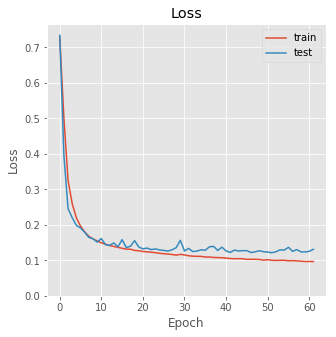

In [12]:
 def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax.plot(history.history['loss'])
    if validation:
        ax.plot(history.history['val_loss'])
    ax.set_title('Loss')
    ax.set_ylabel('Loss')
    ax.set_ylim(bottom=0.)
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'test'])
    
    plt.savefig('./fig/loss_curve_2000.pdf')
    
plot_history(history, validation=True)

# Bayesian neural network: stochastic feed forward

In [13]:
# It takes a time !! 
num = len(X_test)
list_stochastic_feed_forwards = [3,5,10,15,20,30]
result_dict = {}
for ind, num_stochastic_T in enumerate(list_stochastic_feed_forwards):
    start = time.time()
    alea_list = []
    epis_list = []
    dice_list = []
    for i in range(num):
        image = X_test[i]
        gt    = Y_test[i]
        prediction, aleatoric, epistemic, scores = utils.predict(model, image, gt, T=num_stochastic_T)
        alea_list.append(np.mean(aleatoric))
        epis_list.append(np.mean(epistemic))
        dice_list.append(scores[0])
    
    end = time.time()
    print('-'*30)
    print('T: ', num_stochastic_T)
    print('Exec time per prediction = {:.3f}'.format((end-start)/num))
    print('aleatoric: ', np.mean(alea_list), np.std(alea_list))
    print('epistemic: ', np.mean(epis_list), np.std(epis_list))    
    print('Dice: ', np.mean(dice_list), np.std(dice_list))  
    print('-'*30)
    
    result_dict.update({ '{}'.format(str(num_stochastic_T)) : 
    [num_stochastic_T, (end-start)/num,
     np.mean(alea_list), np.std(alea_list),
     np.mean(epis_list), np.std(epis_list),
     np.mean(dice_list), np.std(dice_list)]} )

------------------------------
T:  3
Exec time per prediction = 0.040
aleatoric:  0.028093895 0.011048832
epistemic:  0.0019001949 0.0010757401
Dice:  0.954391927421093 0.022172437341847217
------------------------------
------------------------------
T:  5
Exec time per prediction = 0.058
aleatoric:  0.02808228 0.010990963
epistemic:  0.0022837634 0.0012748033
Dice:  0.9543851999044418 0.022300905966225807
------------------------------
------------------------------
T:  10
Exec time per prediction = 0.104
aleatoric:  0.028062107 0.010985625
epistemic:  0.0025724573 0.001436954
Dice:  0.9542073569297791 0.02234107155845244
------------------------------
------------------------------
T:  15
Exec time per prediction = 0.151
aleatoric:  0.02806841 0.010971129
epistemic:  0.002655848 0.0014709741
Dice:  0.9542989364862442 0.022189525866133607
------------------------------
------------------------------
T:  20
Exec time per prediction = 0.198
aleatoric:  0.028077839 0.0109594995
epistemi

In [14]:
results = np.zeros((5, len(list_stochastic_feed_forwards)))
for ind, num_stochastic_T in enumerate(list_stochastic_feed_forwards):
    results[:, ind] = result_dict[str(num_stochastic_T)][1:6]

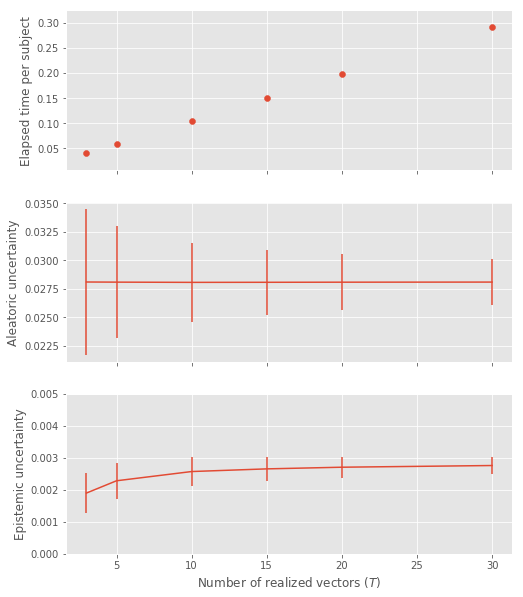

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)
# plot history for loss
ax[0].scatter(list_stochastic_feed_forwards,results[0])
ax[0].set_ylabel('Elapsed time per subject')
ax[1].errorbar(list_stochastic_feed_forwards,results[1], yerr=results[2]/np.sqrt(list_stochastic_feed_forwards))
ax[1].set_ylabel('Aleatoric uncertainty')
ax[2].errorbar(list_stochastic_feed_forwards,results[3], yerr=results[4]/np.sqrt(list_stochastic_feed_forwards))
ax[2].set_ylabel('Epistemic uncertainty')
ax[2].set_xlabel('Number of realized vectors ($T$)')
ax[2].set_ylim(0.00,0.005)
plt.savefig('./fig/elapsed_time_vs_feed_2000.pdf')

In [20]:
# Case T = 5
num = len(X_test)
start = time.time()
list_alea = []
list_epis = []
for i in range(num):
    image = X_test[i]
    gt    = Y_test[i]
    prediction, aleatoric, epistemic, scores = utils.predict(model, image, gt, T=5)
    list_alea.append(aleatoric.reshape(-1))
    list_epis.append(epistemic.reshape(-1))

end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))
print('aleatoric: ', np.mean(list_alea))
print('epistemic: ', np.mean(list_epis))


Exec time per prediction = 0.058
aleatoric:  0.028071176
epistemic:  0.0022882384


In [21]:
list_alea = np.hstack(list_alea)
list_epis = np.hstack(list_epis)

print('aleatoric mean: ', np.mean(list_alea))
print('epistemic mean: ', np.mean(list_epis))

aleatoric mean:  0.028071176
epistemic mean:  0.0022882384


# Bivariate density plot for aleatoric and epistemic uncertainties (Figure 5)

In [22]:
threshold = np.percentile(list_alea, 99)
alea_index = (list_alea > threshold)

/usr/local/lib/python3.5/dist-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


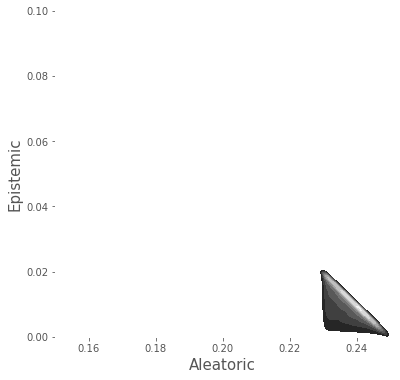

In [23]:
plt.figure(figsize=(6,6))
data = np.vstack([list_alea[alea_index], list_epis[alea_index]]).T
ax = sns.kdeplot(data, shade = True, cmap = "gray", cbar=False)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
ax.set_xlabel('Aleatoric', fontsize = 15)
ax.set_ylabel('Epistemic', fontsize = 15)
ax.set_xlim(0.15, 0.25)
ax.set_ylim(0, 0.1)
plt.savefig('./fig/epis_vs_alea_2000.pdf')

# Conditional expectation of epistemic uncertainty (Table 5)

In [24]:
threshold_99 = np.percentile(list_alea, 99.)
threshold_995 = np.percentile(list_alea, 99.5)
threshold_999 = np.percentile(list_alea, 99.9)
threshold_9995 = np.percentile(list_alea, 99.95)
print(threshold_99, threshold_995, threshold_999, threshold_9995)
# alea_index = (list_alea > threshold)

0.23005470663309097 0.23666909337043762 0.24404397615790369 0.24564805635809916


In [25]:
print('conditional expectation of epistemic')
print(
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.05) and (list_alea[i] < 0.1)]),
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.1) and (list_alea[i] < 0.15)]),
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.15) and (list_alea[i] < 0.2)]),
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.2) and (list_alea[i] < 0.25)])
    )

conditional expectation of epistemic
0.0066719633 0.01385676 0.020454032 0.015572889
